# pyzmq perf crossover

Sample plots from running `python collect.py` script to generate performance data.

PyZMQ's zero-copy implementation has a nontrivial overhead, due to the requirement to notify Python garbage collection when libzmq is done with a message from its IO thread. Performance optimizations over time and application/machine circumstances change where the crossover is, where zero-copy is more cost than benefit.

In general, it is recommended to only use zero-copy for 'large' messages (at least 10s-100s of kB) because the bookkeeping overhead is significantly greater than small `memcpy` calls.

In [1]:
import matplotlib.pyplot as plt
import pickle

plt.ion()

## Throughput

Throughput tests measure sending messages on a PUSH-PULL pair as fast as possible. These numbers count the time from first `recv` to the last.

In [2]:
with open('thr.pickle', 'rb') as f:
    thr = pickle.load(f)

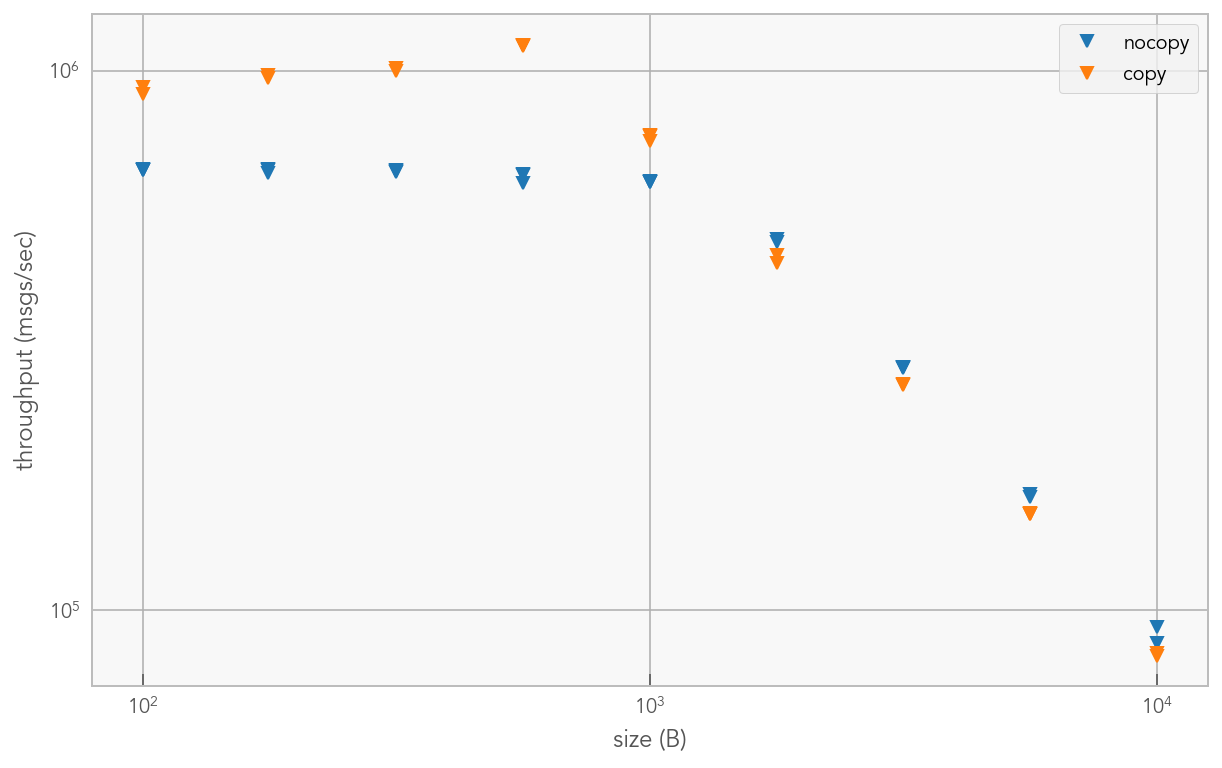

In [3]:
for copy, df in thr.groupby('copy'):
    plt.loglog(df['size'], df.throughput, 'v', label='copy' if copy else 'nocopy')
plt.xlabel('size (B)')
plt.ylabel('throughput (msgs/sec)')
plt.legend(loc=0)


Scaled plot, showing ratio of zero-copy to copy throughput performance:

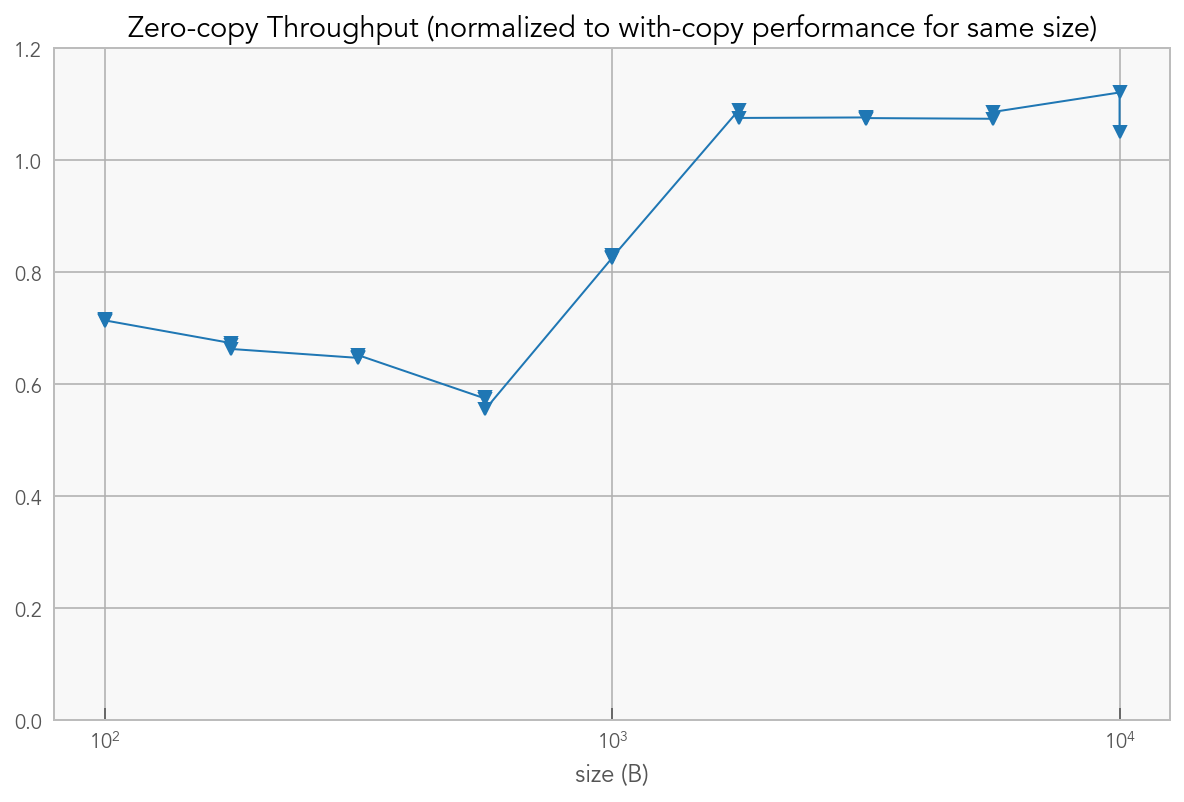

In [4]:
copy_mean = thr[thr['copy']].groupby('size').throughput.mean()
no_copy = thr[thr['copy'] == False]
reference = copy_mean[no_copy['size']]
plt.semilogx(no_copy['size'], (no_copy.throughput / reference.data), '-v')
plt.ylim(0, 1.2)
plt.xlabel("size (B)")
plt.title("Zero-copy Throughput (normalized to with-copy performance for same size)")

From the above plot, zero-copy can introduce a 25-50% performance penalty for messages less than 1k.

**Note:** Missing from this report is the observed sender-side performance, where zero-copy has the biggest advantage due to the absence of `memcpy` in the `socket.send()` call.

## Latency

Latency tests measure REQ-REP request/reply cycles, waiting for a reply before sending the next request.

In [5]:
with open('lat.pickle', 'rb') as f:
    lat = pickle.load(f)

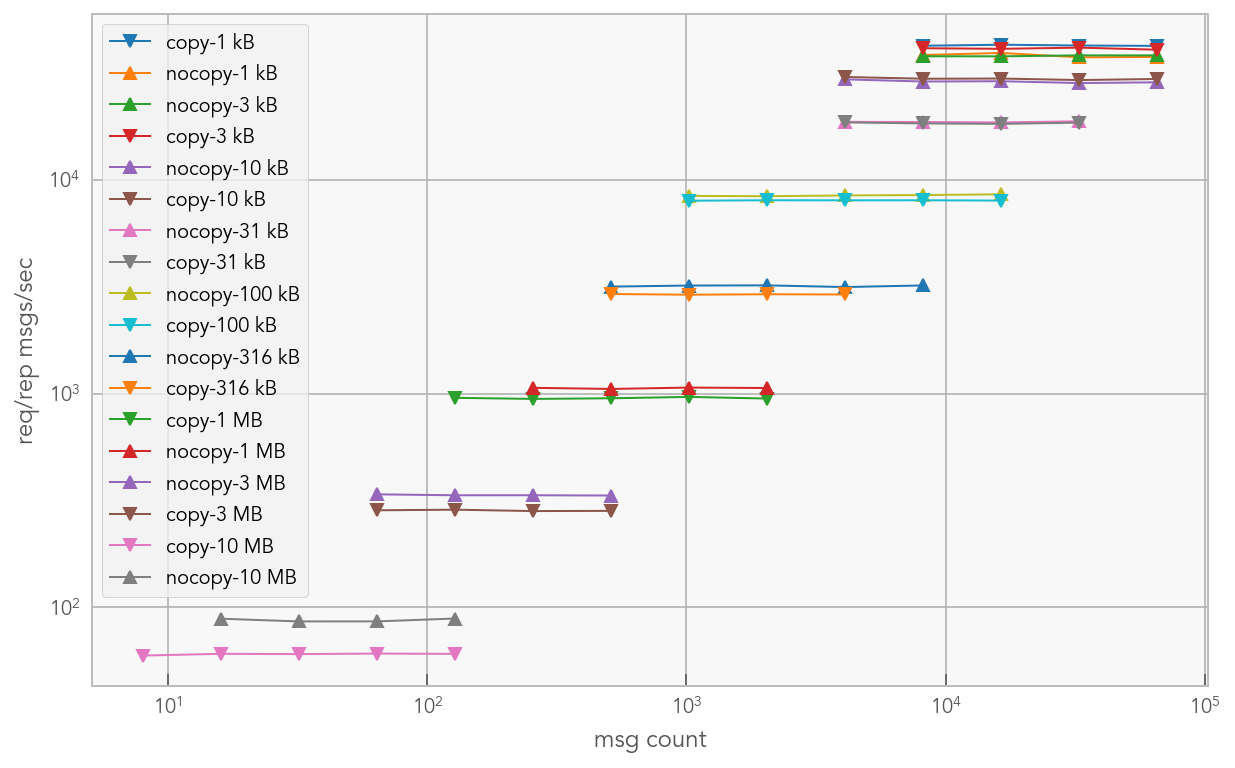

In [6]:
import math

lat = lat.sort_values(by=['count'], ascending=False)

for size, bysize in lat.groupby('size', sort=True):
#     plt.figure()
    y_max = 0
    y_min = np.inf
    for copy, data in bysize.groupby('copy', sort=False):
        mark = '-' + ('v' if copy else '^')
        copy_s = 'copy' if copy else 'nocopy'
        if size >= 1e6:
            size_s = '%i MB' % (size // 1e6)
        elif size >= 1e3:
            size_s = '%i kB' % (size // 1e3)
        else:
            size_s = '%i B' % size
        msgs_sec = 1e6 / data['latency']
        plt.loglog(data['count'], msgs_sec, mark, label='%s-%s' % (copy_s, size_s))
        tic_below = 10**int(math.log(msgs_sec.min(), 10))
    
    plt.legend(loc=0)

    plt.xlabel('msg count')
    plt.ylabel('req/rep msgs/sec')
